In [1]:
!pip install visualkeras

In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf
from tqdm import tqdm
import shutil
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess_input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import visualkeras
# from google.colab import drive
from PIL import Image

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU device found:', tf.test.gpu_device_name())
else:
    print("No GPU found. Please ensure you've enabled GPU acceleration in Colab (Runtime > Change runtime type > Hardware accelerator > GPU).")

TensorFlow version: 2.5.0
GPU device found: /device:GPU:0


In [4]:
# Mount Google Drive to access files and folders
# drive.mount('/content/PKCV')

In [5]:
# Define the base directory where all images are stored
BASE_DIR = 'C:\Downloads\ComputerVision\dataset_butterfly'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')

class_names = os.listdir(train_dir)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

IMG_SIZE = (224, 224)

In [6]:
def load_data(directory):
    images = []
    labels = []

    # Load Haar Cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for folder in os.listdir(directory):
        if folder in class_names:
            label = class_names.index(folder)

            for file in os.listdir(os.path.join(directory, folder)):
                img_path = os.path.join(os.path.join(directory, folder), file)

                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.webp')):
                    image = cv2.imread(img_path)

                    if image is not None:
                        # Detect faces in the image
                        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

                        if len(faces) > 0:
                            # Assuming only one face, crop around the first detected face
                            x, y, w, h = faces[0]
                            cropped_image = image[y:y+h, x:x+w]
                        else:
                            # If no faces detected, use the whole image
                            cropped_image = image

                        # Resize the cropped image to IMG_SIZE
                        cropped_image = cv2.resize(cropped_image, IMG_SIZE)

                        images.append(cropped_image)
                        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")

    # Shuffle the data using sklearn.utils.shuffle
    images, labels = shuffle(images, labels, random_state=25)

    return images, labels

In [7]:
train_images, train_labels = load_data(train_dir)
test_images, test_labels = load_data(test_dir)

In [8]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [9]:
def display_examples(class_names, images, labels):
    figsize = (20, 20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Contoh Sampel Dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype(np.uint8))
        plt.xlabel(class_names[labels[i]])
    plt.show()

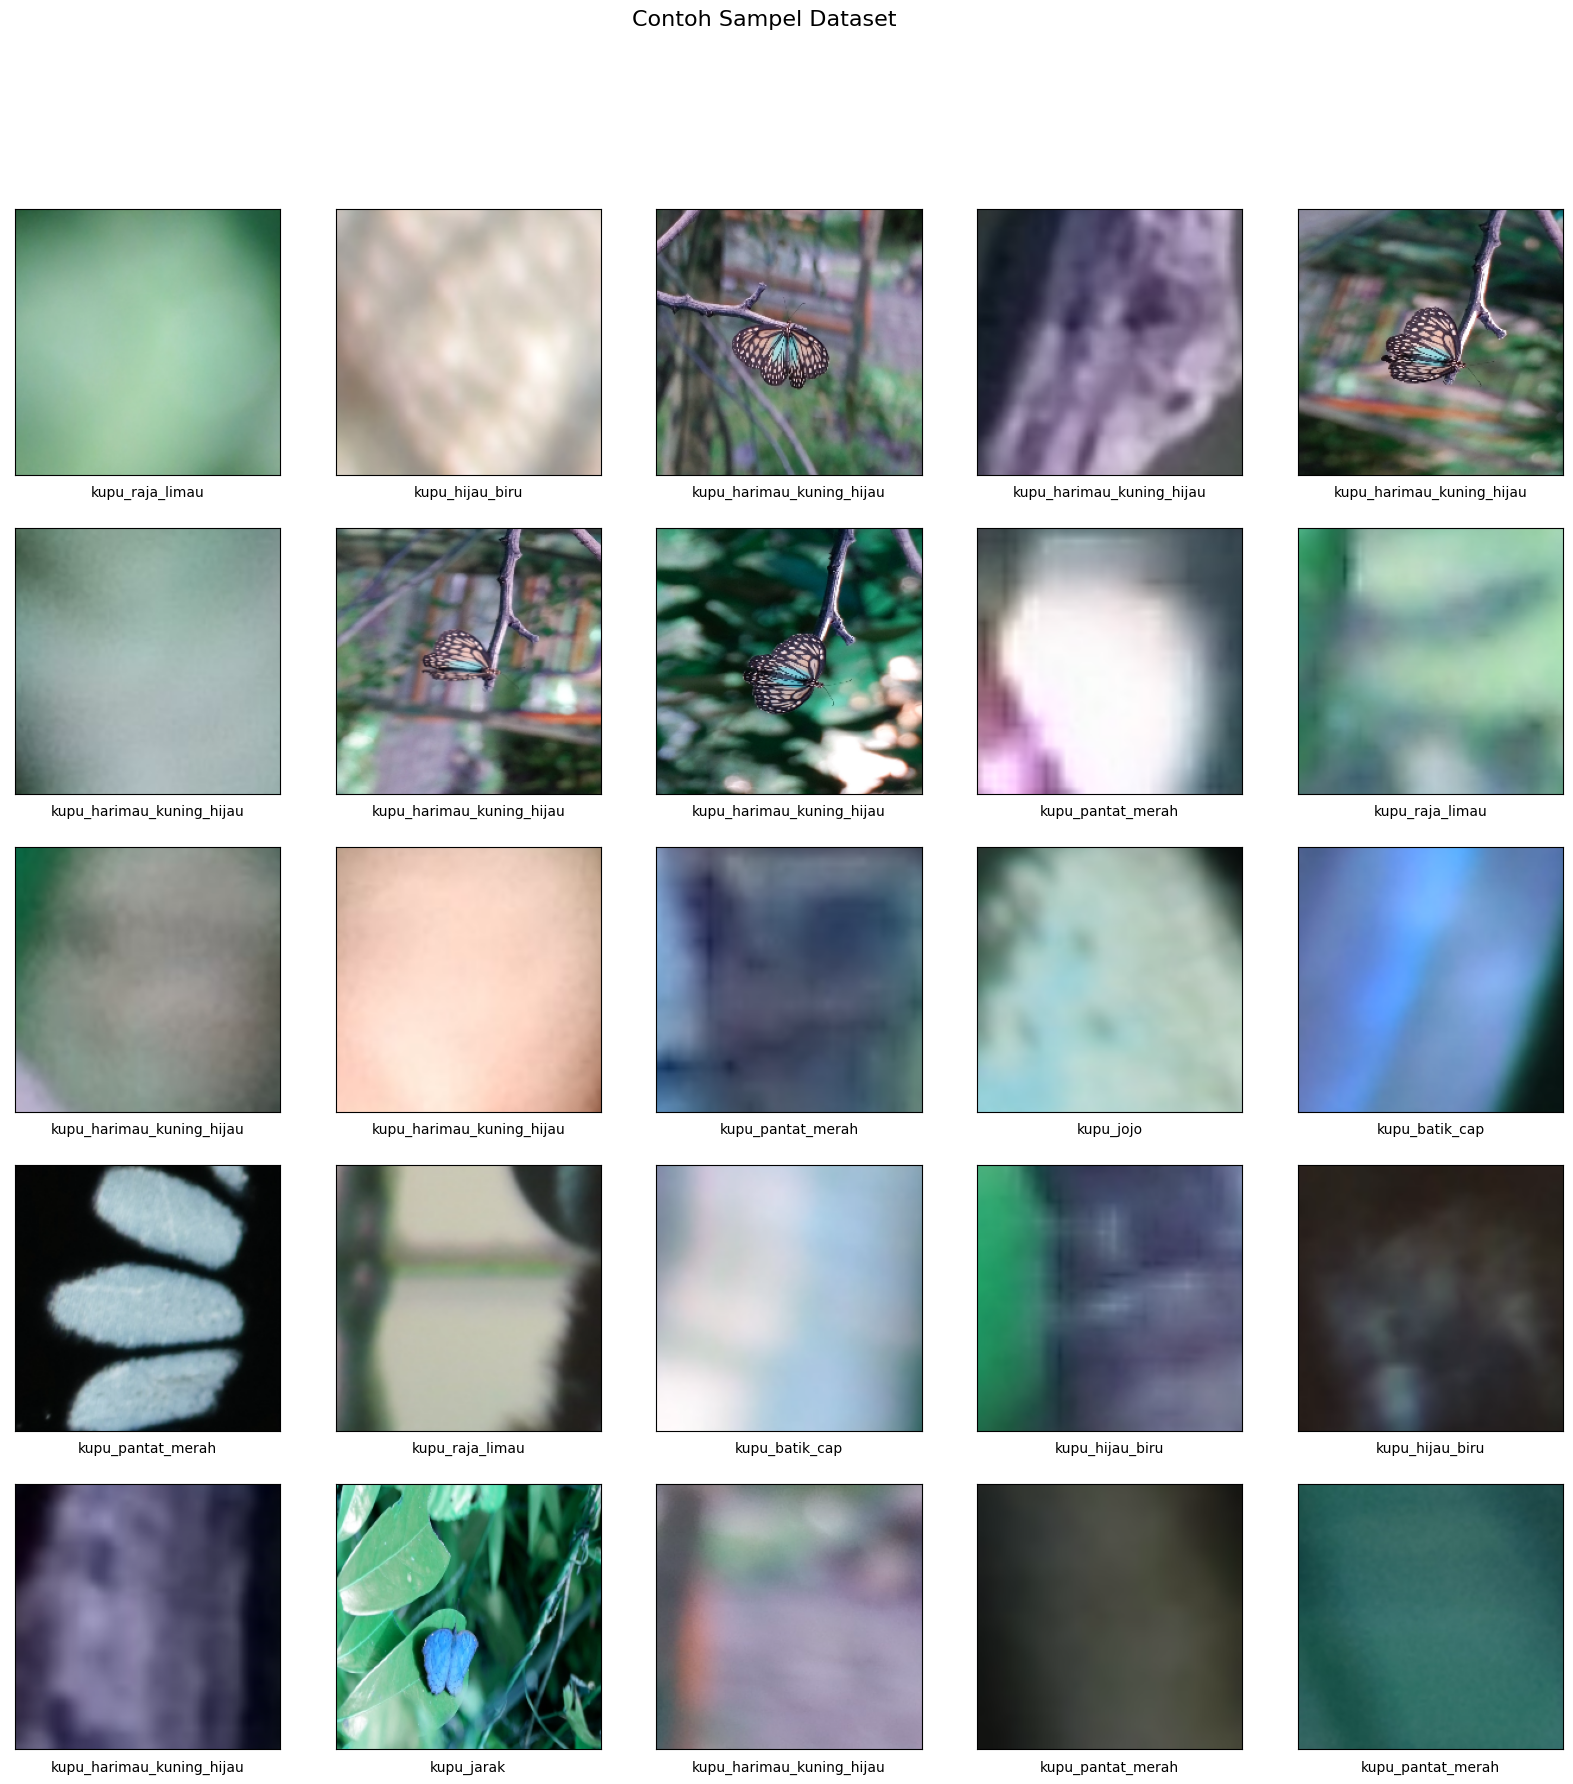

In [10]:
display_examples(class_names, train_images, train_labels)

In [11]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

In [12]:
train_dataset = train_data.flow_from_directory(train_dir,
                                               target_size=IMG_SIZE,
                                               batch_size=16,
                                               class_mode='sparse')

validation_dataset = validation_data.flow_from_directory(val_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=16,
                                                         class_mode='sparse')

test_dataset = validation_data.flow_from_directory(test_dir,
                                                   target_size=IMG_SIZE,
                                                   batch_size=16,
                                                   class_mode='sparse')

Found 425 images belonging to 8 classes.
Found 64 images belonging to 8 classes.
Found 121 images belonging to 8 classes.


In [13]:
# Preprocess the images for InceptionV3 and Xception
train_images = tf.keras.applications.inception_v3.preprocess_input(train_images)
test_images = tf.keras.applications.inception_v3.preprocess_input(test_images)

In [14]:
# Define the input shape according to the model
input_shape = IMG_SIZE + (3,)  # For InceptionV3 and Xception

In [15]:
# Membangun model dengan InceptionV3 base
def build_model_inceptionv3(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Membangun model dengan Xception base
def build_model_xception(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Membangun model dengan GoogLeNet base
def build_model_googlenet(base_model):
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [16]:
# Membuat model InceptionV3
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
# Membuat model kustom di atas InceptionV3
inception_custom_model = build_model_inceptionv3(inception_model)

# Membuat model Xception
xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
# Membuat model kustom di atas Xception
xception_custom_model = build_model_xception(xception_model)

# Membuat model GoogLeNet
googlenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
# Membuat model kustom di atas GoogLeNet
googlenet_custom_model = build_model_googlenet(googlenet_model)

In [17]:
# Penyesuaian Learning Rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [18]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [19]:
# Compile the models with adjusted learning rate
inception_custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
googlenet_custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
xception_custom_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
# Train the models
inception_history = inception_custom_model.fit(
    train_images, train_labels, batch_size=16,
    epochs=100,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
27/27 [==============================] - 18s 188ms/step - loss: 2.0657 - accuracy: 0.1929 - val_loss: 4227.3838 - val_accuracy: 0.1653
Epoch 2/100
27/27 [==============================] - 3s 96ms/step - loss: 1.9560 - accuracy: 0.1788 - val_loss: 324.3304 - val_accuracy: 0.1653
Epoch 3/100
27/27 [==============================] - 3s 96ms/step - loss: 1.8503 - accuracy: 0.2141 - val_loss: 3.1640 - val_accuracy: 0.2810
Epoch 4/100
27/27 [==============================] - 3s 95ms/step - loss: 1.8095 - accuracy: 0.2400 - val_loss: 2.3272 - val_accuracy: 0.2975
Epoch 5/100
27/27 [==============================] - 3s 95ms/step - loss: 1.7515 - accuracy: 0.2635 - val_loss: 6.6989 - val_accuracy: 0.2149
Epoch 6/100
27/27 [==============================] - 3s 93ms/step - loss: 1.7938 - accuracy: 0.2988 - val_loss: 2.1997 - val_accuracy: 0.2810
Epoch 7/100
27/27 [==============================] - 2s 93ms/step - loss: 1.7387 - accuracy: 0.2659 - val_loss: 1237.9540 - val_accuracy: 0.1

In [21]:
googlenet_history = googlenet_custom_model.fit(
    train_images, train_labels, batch_size=16,
    epochs=100,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
27/27 [==============================] - 15s 266ms/step - loss: 26.2809 - accuracy: 0.2376 - val_loss: 2731.9993 - val_accuracy: 0.1570
Epoch 2/100
27/27 [==============================] - 4s 138ms/step - loss: 8.7689 - accuracy: 0.3482 - val_loss: 132446.1406 - val_accuracy: 0.1736
Epoch 3/100
27/27 [==============================] - 4s 138ms/step - loss: 5.4618 - accuracy: 0.3247 - val_loss: 127196.0469 - val_accuracy: 0.1570
Epoch 4/100
27/27 [==============================] - 4s 138ms/step - loss: 3.8275 - accuracy: 0.4165 - val_loss: 39027.2578 - val_accuracy: 0.1983
Epoch 5/100
27/27 [==============================] - 4s 138ms/step - loss: 3.5079 - accuracy: 0.3812 - val_loss: 913.3051 - val_accuracy: 0.2727
Epoch 6/100
27/27 [==============================] - 4s 138ms/step - loss: 1.9951 - accuracy: 0.4259 - val_loss: 139.2301 - val_accuracy: 0.3140
Epoch 7/100
27/27 [==============================] - 4s 138ms/step - loss: 1.4389 - accuracy: 0.5153 - val_loss: 55.757

In [22]:
xception_history = xception_custom_model.fit(
    train_images, train_labels, batch_size=16,
    epochs=100,
    validation_data=(test_images, test_labels),
    callbacks=[reduce_lr, early_stopping])

Epoch 1/100
27/27 [==============================] - 12s 291ms/step - loss: 1.9805 - accuracy: 0.3106 - val_loss: 2.3614 - val_accuracy: 0.2314
Epoch 2/100
27/27 [==============================] - 6s 221ms/step - loss: 1.4935 - accuracy: 0.4965 - val_loss: 2.8063 - val_accuracy: 0.3554
Epoch 3/100
27/27 [==============================] - 6s 216ms/step - loss: 1.1802 - accuracy: 0.6165 - val_loss: 4.9330 - val_accuracy: 0.3802
Epoch 4/100
27/27 [==============================] - 6s 212ms/step - loss: 0.9929 - accuracy: 0.6682 - val_loss: 2.2301 - val_accuracy: 0.4215
Epoch 5/100
27/27 [==============================] - 6s 217ms/step - loss: 0.9310 - accuracy: 0.7012 - val_loss: 3.0868 - val_accuracy: 0.3802
Epoch 6/100
27/27 [==============================] - 6s 221ms/step - loss: 0.7526 - accuracy: 0.7624 - val_loss: 6.0572 - val_accuracy: 0.4050
Epoch 7/100
27/27 [==============================] - 6s 220ms/step - loss: 0.6234 - accuracy: 0.8188 - val_loss: 1.8008 - val_accuracy: 0.487

In [23]:
def plot_accuracy_loss(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title(f'{model_name} Training & Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{model_name} Training & Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

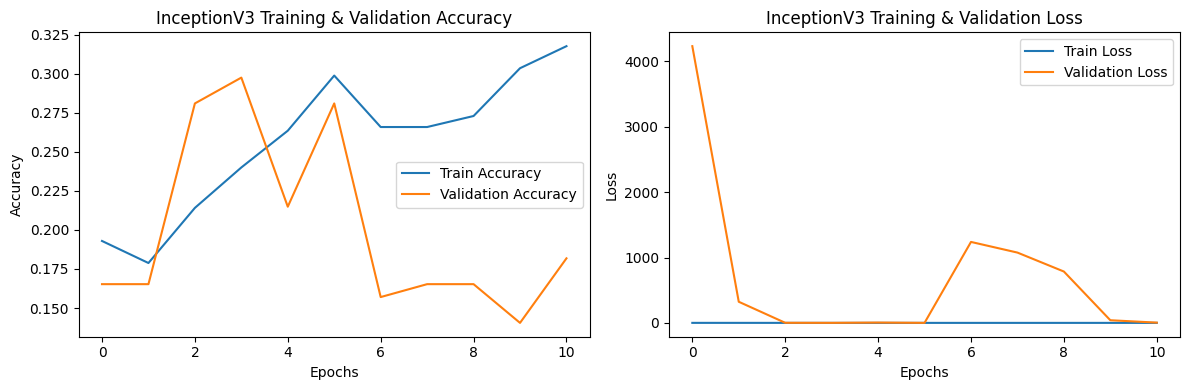

In [24]:
plot_accuracy_loss(inception_history, 'InceptionV3')

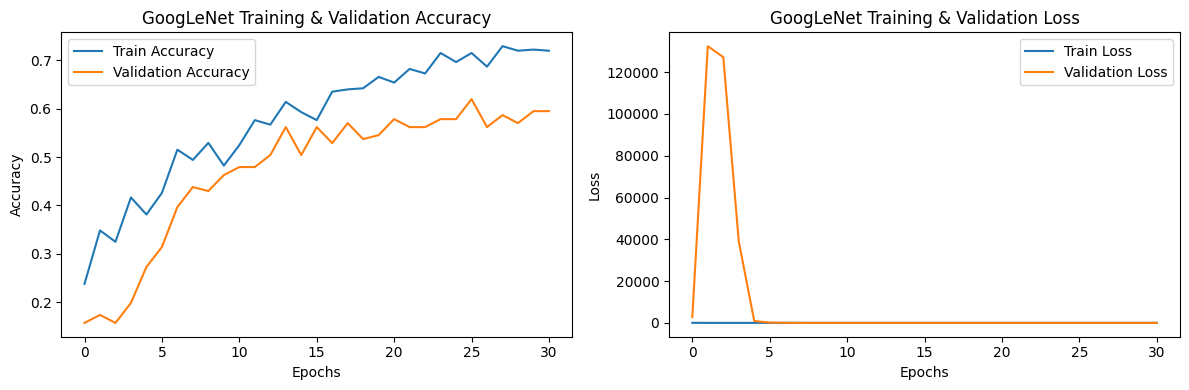

In [25]:
plot_accuracy_loss(googlenet_history, 'GoogLeNet')

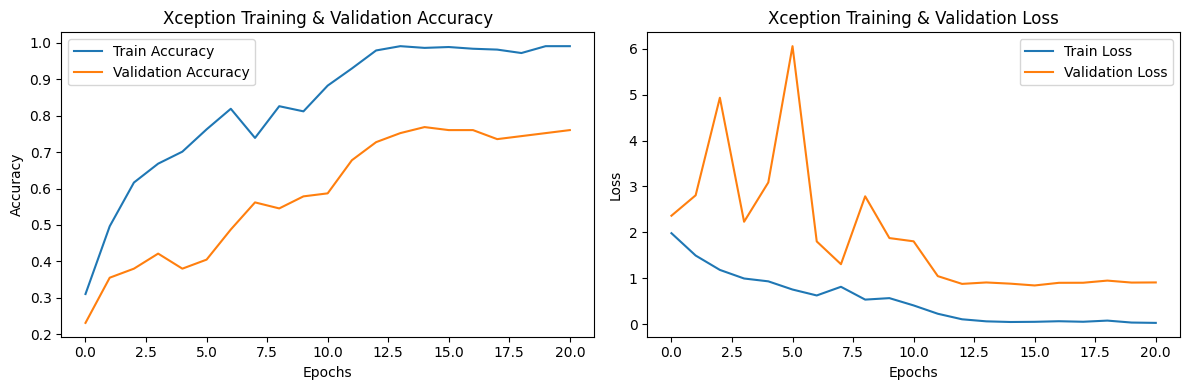

In [26]:
plot_accuracy_loss(xception_history, 'Xception')

In [27]:
# # Save the models
inception_custom_model.save('C:\Downloads\ComputerVision\H5_Model\inception_custom_model.h5')
googlenet_custom_model.save('C:\Downloads\ComputerVision\H5_Model\googlenet_custom_model.h5')
xception_custom_model.save('C:\Downloads\ComputerVision\H5_Model\Xception_custom_model.h5')

c:\Users\Hafiz Atsal\miniconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
# Summarize models
print("InceptionV3 Model Summary:")
inception_custom_model.summary()
plot_model(inception_custom_model, show_shapes=True, to_file='inception_module.png')

InceptionV3 Model Summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
___________________________________________________________________

In [29]:
print("GoogLeNet Model Summary:")
googlenet_custom_model.summary()
plot_model(googlenet_custom_model, show_shapes=True, to_file='googlenet_module.png')

GoogLeNet Model Summary:
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________

In [30]:
print("Xception Model Summary:")
xception_custom_model.summary()
plot_model(xception_custom_model, show_shapes=True, to_file='xception_module.png')

Xception Model Summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________

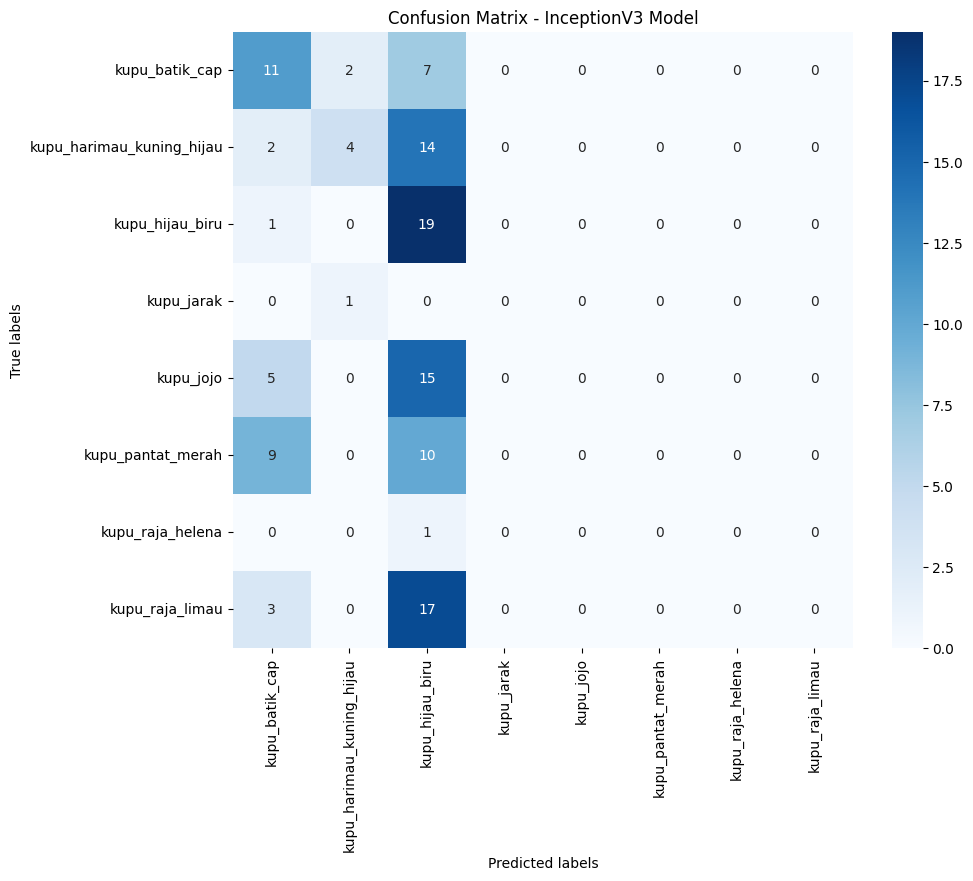

In [31]:
# Plot confusion matrix for InceptionV3 model
inception_predictions = inception_custom_model.predict(test_images)
inception_predictions_labels = np.argmax(inception_predictions, axis=1)
inception_conf_matrix = confusion_matrix(test_labels, inception_predictions_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(inception_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - InceptionV3 Model')
plt.show()

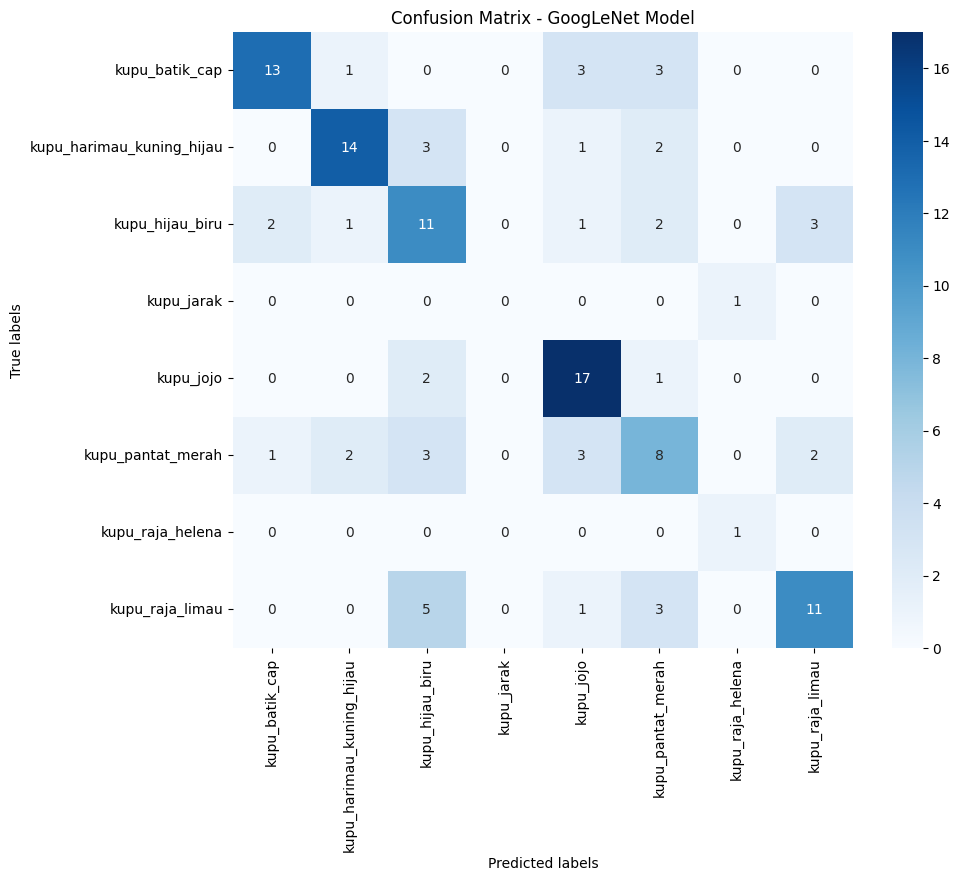

In [32]:
# Plot confusion matrix for GoogLeNet model
googlenet_predictions = googlenet_custom_model.predict(test_images)
googlenet_predictions_labels = np.argmax(googlenet_predictions, axis=1)
googlenet_conf_matrix = confusion_matrix(test_labels, googlenet_predictions_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(googlenet_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - GoogLeNet Model')
plt.show()

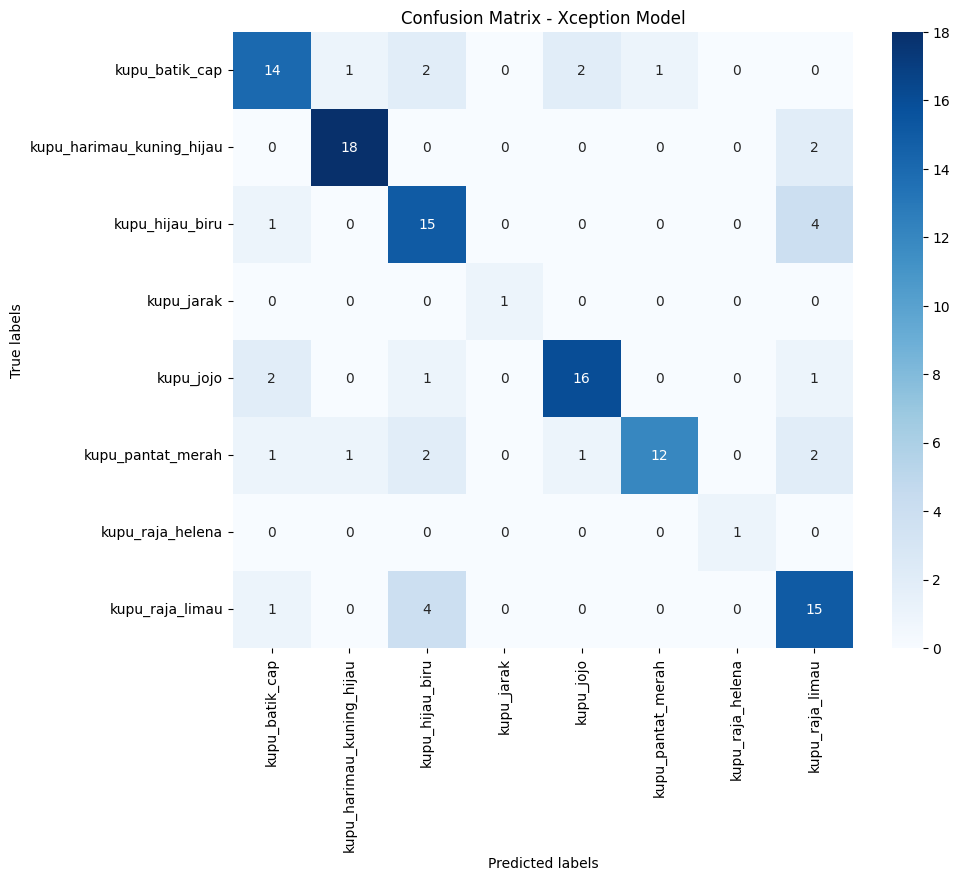

In [33]:
# Plot confusion matrix for Xception model
xception_predictions = xception_custom_model.predict(test_images)
xception_predictions_labels = np.argmax(xception_predictions, axis=1)
xception_conf_matrix = confusion_matrix(test_labels, xception_predictions_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(xception_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Xception Model')
plt.show()

In [34]:
def calculate_metrics(conf_matrix):
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1_score

In [35]:
inception_precision, inception_recall, inception_f1_score = calculate_metrics(inception_conf_matrix)

c:\Users\Hafiz Atsal\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [36]:
googlenet_precision, googlenet_recall, googlenet_f1_score = calculate_metrics(googlenet_conf_matrix)

c:\Users\Hafiz Atsal\miniconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [37]:
xception_precision, xception_recall, xception_f1_score = calculate_metrics(xception_conf_matrix)

In [38]:
metrics_df = pd.DataFrame({
    'class_name': class_names,
    'InceptionV3_precision': inception_precision,
    'InceptionV3_recall': inception_recall,
    'InceptionV3_F1_score': inception_f1_score,
    'GoogLeNet_precision': googlenet_precision,
    'GoogLeNet_recall': googlenet_recall,
    'GoogLeNet_F1_score': googlenet_f1_score,
    'Xception_precision': xception_precision,
    'Xception_recall': xception_recall,
    'Xception_F1_score': xception_f1_score
})

In [39]:
metrics_df

class_name  InceptionV3_precision  InceptionV3_recall  \
0             kupu_batik_cap               0.354839                0.55   
1  kupu_harimau_kuning_hijau               0.571429                0.20   
2            kupu_hijau_biru               0.228916                0.95   
3                 kupu_jarak                    NaN                0.00   
4                  kupu_jojo                    NaN                0.00   
5          kupu_pantat_merah                    NaN                0.00   
6           kupu_raja_helena                    NaN                0.00   
7            kupu_raja_limau                    NaN                0.00   

   InceptionV3_F1_score  GoogLeNet_precision  GoogLeNet_recall  \
0              0.431373             0.812500          0.650000   
1              0.296296             0.777778          0.700000   
2              0.368932             0.458333          0.550000   
3                   NaN                  NaN          0.000000   
4                   NaN             0.653846          0.850000   
5                   NaN             0.421053          0.421053   
6                   NaN             0.500000          1.000000   
7                   NaN             0.687500          0.550000   

   GoogLeNet_F1_score  Xception_precision  Xception_recall  Xception_F1_score  
0            0.722222            0.736842         0.700000           0.717949  
1            0.736842            0.900000         0.900000           0.900000  
2            0.500000            0.625000         0.750000           0.681818  
3                 NaN            1.000000         1.000000           1.000000  
4            0.739130            0.842105         0.800000           0.820513  
5            0.421053            0.923077         0.631579           0.750000  
6            0.666667            1.000000         1.000000           1.000000  
7            0.611111            0.625000         0.750000           0.681818

In [40]:
# Visualize models
visualkeras.layered_view(inception_custom_model, to_file='C:\Downloads\ComputerVision\VisualKeras_Model\inception_custom_model_layers.png').show()
visualkeras.layered_view(googlenet_custom_model, to_file='C:\Downloads\ComputerVision\VisualKeras_Model\googlenet_custom_model_layers.png').show()
visualkeras.layered_view(xception_custom_model, to_file='C:\Downloads\ComputerVision\VisualKeras_Model\Xception_custom_model_layers.png').show()

In [41]:
# Fungsi untuk memprediksi gambar yang diunggah menggunakan model yang sudah dilatih
def predict_uploaded_images(image_paths, model):
    predictions_list = []
    for image_path in image_paths:
        # Load and preprocess the image
        img = Image.open(image_path)
        img = img.resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Perform prediction
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions[0])
        predicted_class = class_names[predicted_class_idx]
        confidence = np.max(predictions[0]) * 100

        predictions_list.append((predicted_class, confidence))

    return predictions_list

In [42]:
# Fungsi untuk menampilkan gambar yang diunggah
def display_uploaded_images(image_paths):
    fig = plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths, start=1):
        img = Image.open(image_path)
        plt.subplot(1, len(image_paths), i)
        plt.imshow(img)
        plt.axis('off')

        # Extract class name from image file name
        class_name = os.path.splitext(os.path.basename(image_path))[0]
        plt.title(class_name)
    plt.show()

In [43]:
# Definisikan direktori dasar dan memuat gambar yang diunggah
BASE_DIR = 'C:\Downloads\ComputerVision\data_testing'
uploaded_image_filenames = os.listdir(BASE_DIR)
uploaded_image_paths = [os.path.join(BASE_DIR, filename) for filename in uploaded_image_filenames]

In [44]:
# Memuat model yang telah disimpan
inception_custom_model = load_model('C:\Downloads\ComputerVision\H5_Model\inception_custom_model.h5')
googlenet_custom_model = load_model('C:\Downloads\ComputerVision\H5_Model\googlenet_custom_model.h5')
xception_custom_model = load_model('C:\Downloads\ComputerVision\H5_Model\Xception_custom_model.h5')

In [45]:
# Melakukan prediksi menggunakan model yang sudah dilatih
inception_predictions = predict_uploaded_images(uploaded_image_paths, inception_custom_model)
googlenet_predictions = predict_uploaded_images(uploaded_image_paths, googlenet_custom_model)
xception_predictions = predict_uploaded_images(uploaded_image_paths, xception_custom_model)

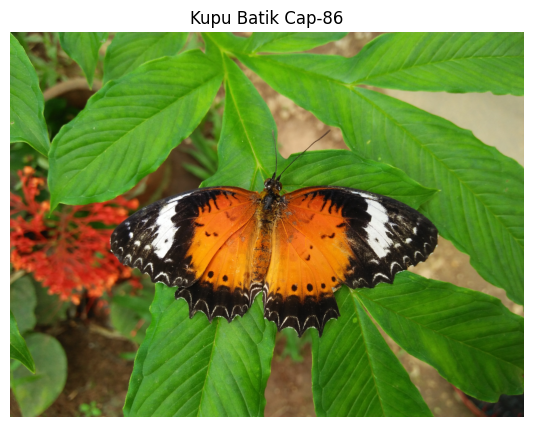

Image: Kupu Batik Cap-86
InceptionV3 Prediction: kupu_harimau_kuning_hijau
InceptionV3 Confidence: 99.94%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 45.18%
Xception Prediction: kupu_raja_limau
Xception Confidence: 56.99%



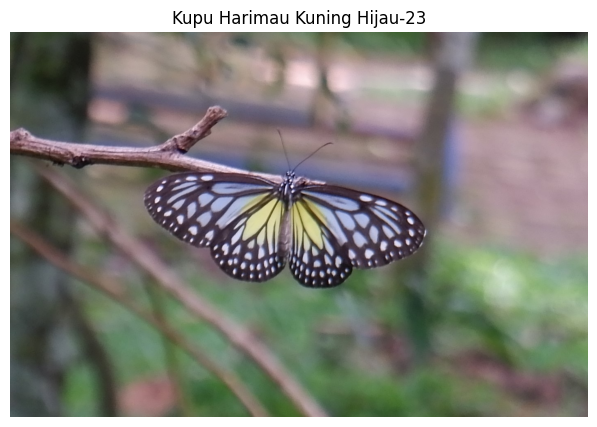

Image: Kupu Harimau Kuning Hijau-23
InceptionV3 Prediction: kupu_harimau_kuning_hijau
InceptionV3 Confidence: 100.00%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 47.73%
Xception Prediction: kupu_harimau_kuning_hijau
Xception Confidence: 99.73%



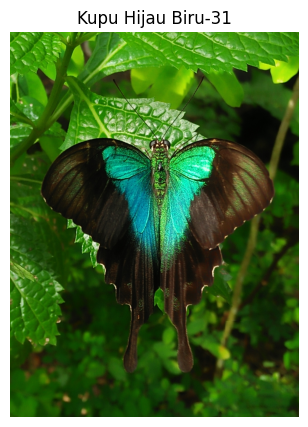

Image: Kupu Hijau Biru-31
InceptionV3 Prediction: kupu_hijau_biru
InceptionV3 Confidence: 36.16%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 37.67%
Xception Prediction: kupu_pantat_merah
Xception Confidence: 63.51%



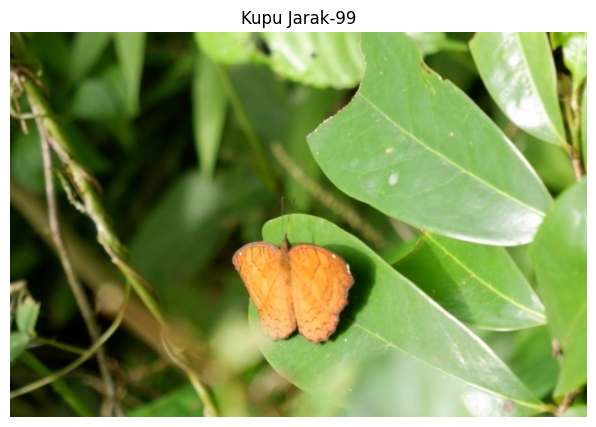

Image: Kupu Jarak-99
InceptionV3 Prediction: kupu_hijau_biru
InceptionV3 Confidence: 24.38%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 50.31%
Xception Prediction: kupu_jarak
Xception Confidence: 97.50%



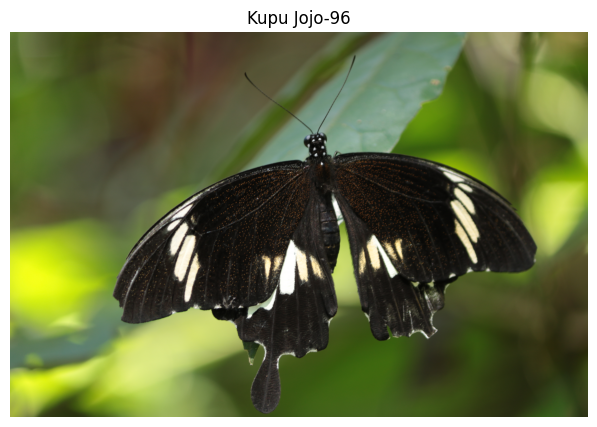

Image: Kupu Jojo-96
InceptionV3 Prediction: kupu_hijau_biru
InceptionV3 Confidence: 36.21%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 54.29%
Xception Prediction: kupu_hijau_biru
Xception Confidence: 41.92%



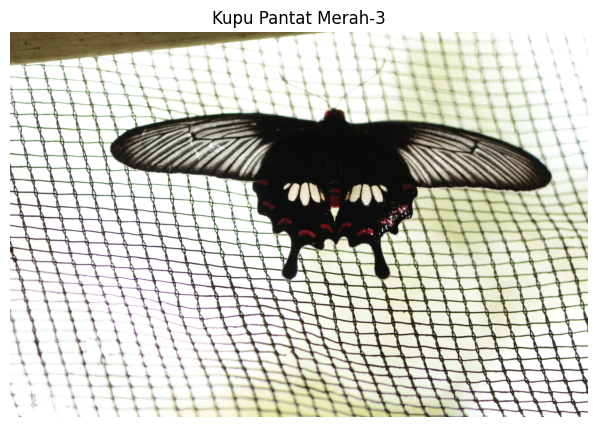

Image: Kupu Pantat Merah-3
InceptionV3 Prediction: kupu_harimau_kuning_hijau
InceptionV3 Confidence: 100.00%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 64.06%
Xception Prediction: kupu_harimau_kuning_hijau
Xception Confidence: 50.56%



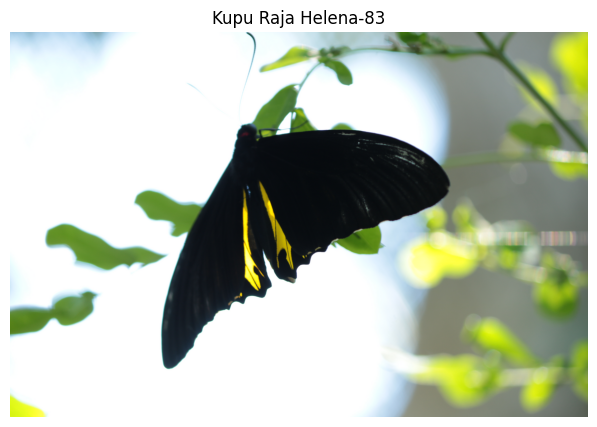

Image: Kupu Raja Helena-83
InceptionV3 Prediction: kupu_hijau_biru
InceptionV3 Confidence: 40.70%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 52.88%
Xception Prediction: kupu_hijau_biru
Xception Confidence: 32.58%



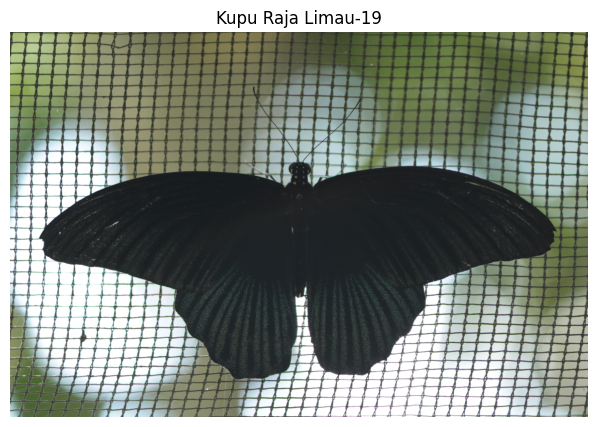

Image: Kupu Raja Limau-19
InceptionV3 Prediction: kupu_harimau_kuning_hijau
InceptionV3 Confidence: 22.79%
GoogLeNet Prediction: kupu_hijau_biru
GoogLeNet Confidence: 47.19%
Xception Prediction: kupu_raja_limau
Xception Confidence: 80.52%



In [46]:
# Menampilkan hasil prediksi
for i, image_path in enumerate(uploaded_image_paths, start=1):
    display_uploaded_images([image_path])
    print("Image:", os.path.splitext(os.path.basename(image_path))[0])
    print("InceptionV3 Prediction:", inception_predictions[i-1][0])
    print("InceptionV3 Confidence: {:.2f}%".format(inception_predictions[i-1][1]))
    print("GoogLeNet Prediction:", googlenet_predictions[i-1][0])
    print("GoogLeNet Confidence: {:.2f}%".format(googlenet_predictions[i-1][1]))
    print("Xception Prediction:", xception_predictions[i-1][0])
    print("Xception Confidence: {:.2f}%".format(xception_predictions[i-1][1]))
    print()